# Investigate key demographics results for nAHD, deltaI, PR (TX99)


Created: 29/02/2024

To do:
- to da_nAHD etc. add a variable or attribute corresponding to the target year/warming level for traceability. 
- barplots: have code to do this for children versus 'adults' with different definitions in other script - potentially do this to have a "children" bar aggregated to the left of the other ages...(or rolling 18 year brackets)

In [1]:
# necessary: netcdf4-python, regionmask, (xarray, geopandas), openpyxl, cartopy (statsmodels?)

import numpy as np
import pandas as pd
import os, glob, re 
import math
import xarray as xr
import geopandas as gpd
import regionmask as regionmask
import dask
import matplotlib.pyplot as plt
import netCDF4
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.ndimage import gaussian_filter

%matplotlib inline

# import my variables settings functions from other scripts
from settings import *

# import fxns 
from functions import *
from utils import *
from plotscript import *

/apps/brussel/RL8/skylake/software/Python/3.10.4-GCCcore-11.3.0/lib/python3.10/site-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
/apps/brussel/RL8/skylake/software/statsmodels/0.13.1-foss-2022a/lib/python3.10/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
start_message() # change indir to indir obs and datasets to datasets obs in start message

flags: {'models': 'ISIMIP3b', 'metric': 'WBGT33', 'method': 'fixed_threshold', 'time_method': 'single-year', 'chunk_version': 2, 'var': 'wbgt'}
var: wbgt
VARs: None
indir_p: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/InputData/climate/atmosphere/bias-adjusted/global/daily/
indir_s: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/SecondaryInputData/climate/atmosphere/bias-adjusted/global/daily/
indir: None
GCMs: ['CanESM5', 'CNRM-CM6-1', 'GFDL-ESM4', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0']
datasets: None
lat_chunk: 90
lon_chunk: 120
time_chunk: -1
outdirs: /data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output
figdirs: /data/brussel/vo/000/bvo00012/vsc10419/attr-hw/figures
start_pi: 1850
end_pi: 1900
target_years: 2022
observed_warming_path: ../../data/gmst/gmst-obs/forster2023/decadal_averages.csv
dir_gmst_models: ../../data/gmst/gmst-models-isimip3b
outdirnames: {'TX99': 'output_dec23-8736300-tx99', 'TX95': 'output_jan24-8812631-tx95', 'TX90': 'output_dec23-8

In [3]:
from dask.distributed import Client 
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 2,Total memory: 60.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41927,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 2
Started: Just now,Total memory: 60.00 GiB
Comm: tcp://127.0.0.1:46207,Total threads: 1
Dashboard: http://127.0.0.1:43617/status,Memory: 30.00 GiB
Nanny: tcp://127.0.0.1:43817,


In [4]:
# set figure path for saving

figdir = os.path.join(figdirs, 'fig_apr24-egu')

if not os.path.exists(figdir):
    os.makedirs(figdir)

## open data

(update) outdirnames have changed to outdirnames[metric]

In [5]:
# delta_I 
da_deltaI_TX90 = open_all_deltaI(GCMs, metric='TX90', outdirname=outdirnames['TX90'])
da_deltaI_TX95 = open_all_deltaI(GCMs, metric='TX95', outdirname=outdirnames['TX95'])
da_deltaI_TX99 = open_all_deltaI(GCMs, metric='TX99', outdirname=outdirnames['TX99'])

In [6]:
# nADH
da_nAHD_TX90 = open_all_nAHD(GCMs, metric='TX90', outdirname=outdirnames['TX90']) # change this format so you cant get wrong p1?
da_nAHD_TX95 = open_all_nAHD(GCMs, metric='TX95', outdirname=outdirnames['TX95']) 
da_nAHD_TX99 = open_all_nAHD(GCMs, metric='TX99', outdirname=outdirnames['TX99'])


In [7]:
# PR
da_PR_TX90 = open_all_PR(GCMs, metric='TX90', outdirname=outdirnames['TX90']) 
da_PR_TX95 = open_all_PR(GCMs, metric='TX95', outdirname=outdirnames['TX95'])
da_PR_TX99 = open_all_PR(GCMs, metric='TX99', outdirname=outdirnames['TX99'])


In [8]:
# pre-industrial intensities - not needed here?  
da_pi_TX90 = open_all_TX_preindustrial(GCMs, metric='TX90', outdirname=outdirnames['TX90']) 
da_pi_TX95 = open_all_TX_preindustrial(GCMs, metric='TX95', outdirname=outdirnames['TX95'])
da_pi_TX99 = open_all_TX_preindustrial(GCMs, metric='TX99', outdirname=outdirnames['TX99'])


In [9]:
da_nAHD_TX99

<xarray.DataArray 'number of additional days' (model: 6, lat: 360, lon: 720)>
array([[[-4.52326059e-01, -7.18811572e-01, -1.11850727e+00, ...,
         -7.85427511e-01, -7.18811572e-01, -7.18811572e-01],
        [ 6.46858692e-01,  6.80166662e-01,  7.46782601e-01, ...,
          4.80318844e-01,  6.46858692e-01,  5.80242753e-01],
        [ 6.50923538e+00,  6.57587290e+00,  6.17615557e+00, ...,
          6.47592735e+00,  6.17615557e+00,  6.40931129e+00],
        ...,
        [ 6.87564468e+00,  6.77572107e+00,  6.37600327e+00, ...,
          6.94226074e+00,  6.50923538e+00,  6.54254341e+00],
        [ 2.27899265e+00,  2.21237683e+00,  2.27899265e+00, ...,
          2.41224623e+00,  2.61209416e+00,  2.67870998e+00],
        [ 3.13778996e-01,  2.80471027e-01,  3.47086966e-01, ...,
          3.13778996e-01,  2.80471027e-01,  2.80471027e-01]],

       [[ 2.80963688e+01,  2.80297527e+01,  2.83295670e+01, ...,
          2.80963688e+01,  2.81630058e+01,  2.82629299e+01],
        [ 5.58452988e+01,  5.60451660e+01,  5.56454277e+01, ...,
          5.60118599e+01,  5.58119888e+01,  5.59119148e+01],
        [ 4.73174133e+01,  4.74506683e+01,  4.72507973e+01, ...,
          4.74839745e+01,  4.72174911e+01,  4.75839195e+01],
...
          6.07623196e+00,  6.24277163e+00,  6.24277163e+00],
        [ 1.22050943e+01,  1.23050184e+01,  1.24049425e+01, ...,
          1.21051493e+01,  1.18719931e+01,  1.22384024e+01],
        [ 2.44555426e+00,  2.54547811e+00,  2.71201801e+00, ...,
          2.54547811e+00,  2.44555426e+00,  2.54547811e+00]],

       [[ 5.07775402e+00,  5.07775402e+00,  4.74463081e+00, ...,
          4.71132278e+00,  4.74463081e+00,  4.81124687e+00],
        [ 2.18003998e+01,  2.11341534e+01,  2.21668320e+01, ...,
          2.15672226e+01,  2.19336548e+01,  2.13007164e+01],
        [ 1.07074976e+01,  1.00412512e+01,  1.04409895e+01, ...,
          1.05409355e+01,  1.03743744e+01,  1.01411743e+01],
        ...,
        [ 4.37819958e+00,  4.44481564e+00,  4.41150761e+00, ...,
          4.54476118e+00,  4.54476118e+00,  4.44481564e+00],
        [ 9.84138107e+00,  9.87468910e+00,  9.90799713e+00, ...,
          9.84138107e+00,  9.77474308e+00,  9.70812798e+00],
        [ 1.04698944e+00,  9.80373502e-01,  1.11362708e+00, ...,
          8.47119868e-01,  1.18024302e+00,  9.80373502e-01]]],
      dtype=float32)
Coordinates:
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * model    (model) <U12 'CanESM5' 'CNRM-CM6-1' ... 'MIROC6' 'MRI-ESM2-0'

## calc demographics 

In [10]:
sys.path.append('../population/') # make this a module i can pip install and import ! 
from population_demographics_climate import * # move / rename this when good ! 


In [11]:
d_countries = preprocess_all_country_population_data()
gs_population_global = get_gridscale_population_global( 
    d_countries,
    startyear=2022,
    endyear=None,
    save=False # change where this gets saved !!!! now its in package folder
)

interpolating cohort sizes per country
after interpolation and mean-preserving correction there are some neg numbers in 10, Azerbaijan, setting them to zero
after interpolation and mean-preserving correction there are some neg numbers in 98, Libya, setting them to zero
after interpolation and mean-preserving correction there are some neg numbers in 136, Papua New Guinea, setting them to zero
Aruba small, population not calculated
Antigua and Barbuda small, population not calculated
Bahrain small, population not calculated
Barbados small, population not calculated
Federated States of Micronesia small, population not calculated
Grenada small, population not calculated
Guam small, population not calculated
Saint Lucia small, population not calculated
Macao small, population not calculated
Maldives small, population not calculated
Malta small, population not calculated
Singapore small, population not calculated
Tonga small, population not calculated
calculating gridscale population per cou

## Aggregate data to age groups: 

number of people of 10 year age brackets living through at least x AHD and proportion of cohort of 10 year age bracket living through at least x AHD. 


In [12]:
# nAHD 

da_n_people_TX90, da_prop_people_TX90 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, GCMs, da_nAHD_TX90,  x_hot_days = [1,5,10,20,50])
da_n_people_TX95, da_prop_people_TX95 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, GCMs, da_nAHD_TX95,  x_hot_days = [1,5,10,20,50])
da_n_people_TX99, da_prop_people_TX99 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, GCMs, da_nAHD_TX99,  x_hot_days = [1,5,10,20,50])

da_n_people_TX90_hi, da_prop_people_TX90_hi = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, GCMs, da_nAHD_TX90,  x_hot_days = [50,80,100,150])
da_n_people_TX95_hi, da_prop_people_TX95_hi = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, GCMs, da_nAHD_TX95,  x_hot_days = [50,80,100,150])
da_n_people_TX99_hi, da_prop_people_TX99_hi = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, GCMs, da_nAHD_TX99,  x_hot_days = [50,80,100,150])

In [13]:
# delta I 

da_n_people_deltaI_TX99, da_prop_people_deltaI_TX99 = calc_number_proportion_people_atleastdeltaI_10yr(gs_population_global, GCMs, da_deltaI_TX99,  thresholds = [0,0.5,1,1.5,3])
da_n_people_deltaI_TX95, da_prop_people_deltaI_TX95 = calc_number_proportion_people_atleastdeltaI_10yr(gs_population_global, GCMs, da_deltaI_TX95,  thresholds = [0,0.5,1,1.5,3])
da_n_people_deltaI_TX90, da_prop_people_deltaI_TX90 = calc_number_proportion_people_atleastdeltaI_10yr(gs_population_global, GCMs, da_deltaI_TX90,  thresholds = [0,0.5,1,1.5,3])

da_n_people_deltaI_TX99_hi, da_prop_people_deltaI_TX99_hi = calc_number_proportion_people_atleastdeltaI_10yr(gs_population_global, GCMs, da_deltaI_TX99,  thresholds = [1.5,2,2.5,3,3.5])
da_n_people_deltaI_TX95_hi, da_prop_people_deltaI_TX95_hi = calc_number_proportion_people_atleastdeltaI_10yr(gs_population_global, GCMs, da_deltaI_TX95,  thresholds = [1.5,2,2.5,3,3.5])
da_n_people_deltaI_TX90_hi, da_prop_people_deltaI_TX90_hi = calc_number_proportion_people_atleastdeltaI_10yr(gs_population_global, GCMs, da_deltaI_TX90,  thresholds = [1.5,2,2.5,3,3.5])

In [14]:
# PR 

da_n_people_PR_TX99, da_prop_people_PR_TX99 = calc_number_proportion_people_atleastPR_10yr(gs_population_global, GCMs, da_PR_TX99)
da_n_people_PR_TX95, da_prop_people_PR_TX95 = calc_number_proportion_people_atleastPR_10yr(gs_population_global, GCMs, da_PR_TX95)
da_n_people_PR_TX90, da_prop_people_PR_TX90 = calc_number_proportion_people_atleastPR_10yr(gs_population_global, GCMs, da_PR_TX90)

### aggregate nAHD extra fxns (TX99)

In [15]:
# n people and proportion of people: nAHD for 18 year age brackets 
da_n_people_TX99_18y, da_prop_people_TX99_18y = calc_number_proportion_people_atleastxdays_1yr(gs_population_global, 
                                                                                             GCMs, 
                                                                                             da_nAHD_TX99,
                                                                                             x_hot_days = [1, 5, 10, 20, 50], 
                                                                                             ages_values=range(0,100),
                                                                                             grouped = True,
                                                                                             size_win = 18
                                                                                            )

da_n_people_TX99_10y, da_prop_people_TX99_10y = calc_number_proportion_people_atleastxdays_1yr(gs_population_global, 
                                                                                             GCMs, 
                                                                                             da_nAHD_TX99,
                                                                                             x_hot_days = [1, 5, 10, 20, 50], 
                                                                                             ages_values=range(0,100),
                                                                                             grouped = True,
                                                                                             size_win = 10
                                                                                            )

da_n_people_TX99_1y, da_prop_people_TX99_1y = calc_number_proportion_people_atleastxdays_1yr(gs_population_global, 
                                                                                             GCMs, 
                                                                                             da_nAHD_TX99,
                                                                                             x_hot_days = [1, 5, 10, 20, 50], 
                                                                                             ages_values=range(0,100),
                                                                                             grouped = False,
                                                                                             size_win = None
                                                                                            )

In [16]:
# per capita hot days and people-days for all models for (i) 10 year age brackets (ii) 18 year age brackets

# check these wrt my old code to do the same thing !! in dev0 notebook! check why different results 

da_nAHD_TX99_percapita_peopledays_18y = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                           GCMs, 
                                           da_nAHD_TX99,
                                           x_hot_days = [1, 5, 10, 20, 50], 
                                           ages_values=range(0,100),
                                           grouped = True,
                                           size_win = 18
                                           )

da_nAHD_TX99_percapita_peopledays_10y = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                           GCMs, 
                                           da_nAHD_TX99,
                                           x_hot_days = [1, 5, 10, 20, 50], 
                                           ages_values=range(0,100),
                                           grouped = True,
                                           size_win = 10
                                           )

da_nAHD_TX99_percapita_peopledays_1y = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                           GCMs, 
                                           da_nAHD_TX99,
                                           x_hot_days = [1, 5, 10, 20, 50], 
                                           ages_values=range(0,100),
                                           grouped = False,
                                           size_win = None
                                           )

In [17]:
da_nAHD_TX99_percapita_peopledays_18y_nomask = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                           GCMs, 
                                           da_nAHD_TX99,
                                           x_hot_days = [1, 5, 10, 20, 50], 
                                           ages_values=range(0,100),
                                           grouped = True,
                                           size_win = 18,
                                           mask_where_decr=False
                                                                                     
                                           )

da_nAHD_TX99_percapita_peopledays_10y_nomask = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                           GCMs, 
                                           da_nAHD_TX99,
                                           x_hot_days = [1, 5, 10, 20, 50], 
                                           ages_values=range(0,100),
                                           grouped = True,
                                           size_win = 10,
                                           mask_where_decr=False
                                           )

da_nAHD_TX99_percapita_peopledays_1y_nomask = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                           GCMs, 
                                           da_nAHD_TX99,
                                           x_hot_days = [1, 5, 10, 20, 50], 
                                           ages_values=range(0,100),
                                           grouped = False,
                                           size_win = None,
                                           mask_where_decr=False
                                           )

## Make some multi-model plots: nAHD for TX99

### per capita daysdf_10y

In [18]:
da_nAHD_TX99_percapita_peopledays_10y

<xarray.DataArray (model: 6, age_ranges: 10, features: 2)>
array([[[2.18274953e+10, 1.84865766e+01],
        [2.08613793e+10, 1.83093034e+01],
        [1.90781540e+10, 1.79527292e+01],
        [1.75026533e+10, 1.68017298e+01],
        [1.45516386e+10, 1.64790970e+01],
        [1.15798989e+10, 1.52434448e+01],
        [7.94842577e+09, 1.44388726e+01],
        [4.08488021e+09, 1.33867532e+01],
        [1.45336846e+09, 1.24027663e+01],
        [2.36990932e+08, 1.15601459e+01]],

       [[1.67366704e+10, 1.41401001e+01],
        [1.56265307e+10, 1.37065395e+01],
        [1.40160313e+10, 1.32121291e+01],
        [1.28803430e+10, 1.24328906e+01],
        [1.06424605e+10, 1.21343727e+01],
        [8.41599891e+09, 1.11945020e+01],
        [5.79053640e+09, 1.06298666e+01],
        [2.99904577e+09, 9.92981150e+00],
        [1.07414952e+09, 9.24960433e+00],
...
        [2.12291082e+10, 2.06274402e+01],
        [1.85941446e+10, 1.94685980e+01],
        [1.66055058e+10, 1.74119788e+01],
        [1.35077829e+10, 1.66076334e+01],
        [1.05151693e+10, 1.46934407e+01],
        [7.16739939e+09, 1.37251019e+01],
        [3.71198772e+09, 1.26891847e+01],
        [1.32985184e+09, 1.17890909e+01],
        [2.22917004e+08, 1.12445148e+01]],

       [[1.70193535e+10, 1.50643146e+01],
        [1.58901126e+10, 1.46615048e+01],
        [1.42522840e+10, 1.41649033e+01],
        [1.31723351e+10, 1.33233441e+01],
        [1.09301595e+10, 1.30275738e+01],
        [8.71176626e+09, 1.20117201e+01],
        [5.97110181e+09, 1.13006095e+01],
        [3.08696874e+09, 1.04822149e+01],
        [1.09698248e+09, 9.68076758e+00],
        [1.80510353e+08, 9.08797192e+00]]])
Coordinates:
  * age_ranges  (age_ranges) int64 0 10 20 30 40 50 60 70 80 90
  * features    (features) object 'people_days' 'per_capita_days'
  * model       (model) <U12 'CanESM5' 'CNRM-CM6-1' ... 'MIROC6' 'MRI-ESM2-0'

In [19]:
df_10y = da_nAHD_TX99_percapita_peopledays_10y.sel(features='per_capita_days').to_pandas().T
df_10y

model,CanESM5,CNRM-CM6-1,GFDL-ESM4,IPSL-CM6A-LR,MIROC6,MRI-ESM2-0
age_ranges,,,,,,
0,18.486577,14.140100,14.676340,13.541082,21.557734,15.064315
10,18.309303,13.706539,14.370656,13.139098,20.627440,14.661505
20,17.952729,13.212129,14.036799,12.628346,19.468598,14.164903
30,16.801730,12.432891,13.624422,11.674444,17.411979,13.323344
40,16.479097,12.134373,13.489107,11.323635,16.607633,13.027574
50,15.243445,11.194502,12.962621,10.357624,14.693441,12.011720
60,14.438873,10.629867,12.432295,9.844835,13.725102,11.300610
70,13.386753,9.929812,11.980067,9.203068,12.689185,10.482215
80,12.402766,9.249604,11.349682,8.585362,11.789091,9.680768


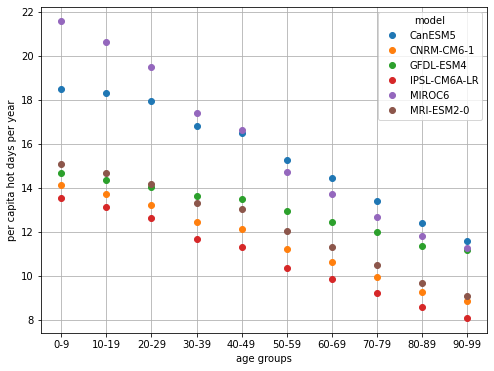

In [20]:
fig, ax = plt.subplots(figsize=(8,6))
df_plot = df_10y
df_plot.plot(marker='o',linestyle='None', ax=ax)
plt.ylabel('per capita hot days per year')
plt.xlabel('age groups')
plt.xticks(df_plot.index);
plt.grid()
ax.set_xticks(ticks=ax.get_xticks(), labels=[f'{x}-{x+9}' for x in df_plot.index], rotation='horizontal');

#plt.savefig(os.path.join(figdir,'percapita_hotdays_10y_TX99.png'), dpi=300, transparent=False)


In [182]:
df_10y.mean(axis=1)

age_ranges
0     16.244358
10    15.802424
20    15.243917
30    14.211468
40    13.843570
50    12.743892
60    12.061930
70    11.278517
80    10.509545
90    10.001882
dtype: float64

In [186]:
df_10y.median(axis=1)

age_ranges
0     14.870327
10    14.516080
20    14.100851
30    13.473883
40    13.258340
50    12.487170
60    11.866452
70    11.231141
80    10.515225
90    10.133005
dtype: float64

In [176]:
df_18y = da_nAHD_TX99_percapita_peopledays_18y.sel(features='per_capita_days').to_pandas().T
df_18y

model,CanESM5,CNRM-CM6-1,GFDL-ESM4,IPSL-CM6A-LR,MIROC6,MRI-ESM2-0
age_ranges,,,,,,
0,18.407814,13.964551,14.552531,13.375834,21.176503,14.899790
18,17.625870,13.004254,13.929266,12.374182,18.929923,13.934120
36,16.340670,12.041323,13.439299,11.229557,16.436147,12.928641
54,14.632121,10.766275,12.585295,9.963940,13.955914,11.483763
72,12.990223,9.654433,11.730875,8.956880,12.331308,10.158286
90,11.560146,8.859335,11.178038,8.081287,11.244515,9.087972


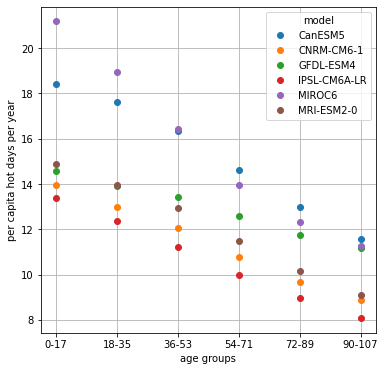

In [192]:
fig, ax = plt.subplots(figsize=(6,6))
df_plot = df_18y
df_plot.plot(marker='o',linestyle='None', ax=ax)
plt.ylabel('per capita hot days per year')
plt.xlabel('age groups')
plt.xticks(df_plot.index);
plt.grid()
ax.set_xticks(ticks=ax.get_xticks(), labels=[f'{x}-{x+17}' for x in df_plot.index], rotation='horizontal');

#plt.savefig(os.path.join(figdir,'percapita_hotdays_18y_TX99.png'), dpi=300, transparent=False)


In [194]:
df_18y.median(axis=1)

age_ranges
0     14.726160
18    13.931693
36    13.183970
54    12.034529
72    10.944580
90    10.133005
dtype: float64

In [185]:
df_18y.mean(axis=1)

age_ranges
0     16.062837
18    14.966269
36    13.735940
54    12.231218
72    10.970334
90    10.001882
dtype: float64

### without masking where nAHD<=0 --> do this for all !! 

In [21]:
df_10y_nomask = da_nAHD_TX99_percapita_peopledays_10y_nomask.sel(features='per_capita_days').to_pandas().T

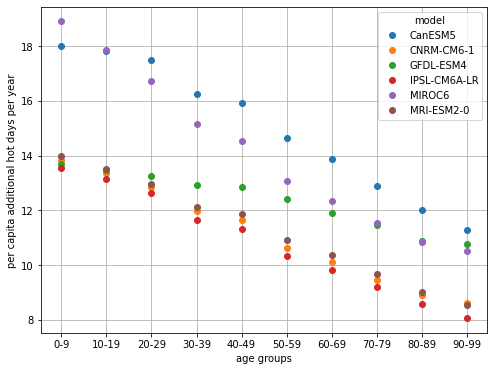

In [24]:
fig, ax = plt.subplots(figsize=(8,6))
df_plot = df_10y_nomask
df_plot.plot(marker='o',linestyle='None', ax=ax)
plt.ylabel('per capita additional hot days per year')
plt.xlabel('age groups')
plt.xticks(df_plot.index);
plt.grid()
ax.set_xticks(ticks=ax.get_xticks(), labels=[f'{x}-{x+9}' for x in df_plot.index], rotation='horizontal');


In [23]:
df_10y_nomask.median(axis=1)

age_ranges
0     13.896666
10    13.487980
20    13.098682
30    12.538518
40    12.364540
50    11.674794
60    11.129641
70    10.575856
80     9.933796
90     9.550227
dtype: float64

### people x days

In [204]:
df_10y_pd = da_nAHD_TX99_percapita_peopledays_10y.sel(features='people_days').to_pandas().T
#df_10y_pd

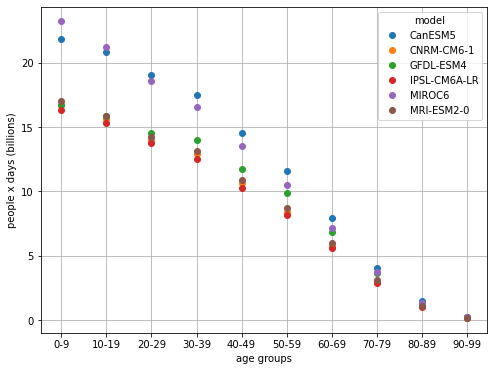

In [214]:
fig, ax = plt.subplots(figsize=(6,6))
df_plot = df_10y_pd / 1e9
df_plot.plot(marker='o',linestyle='None', ax=ax)
plt.ylabel('people x days (billions)')
plt.xlabel('age groups')
plt.xticks(df_plot.index);
plt.grid()
ax.set_xticks(ticks=ax.get_xticks(), labels=[f'{x}-{x+9}' for x in df_plot.index], rotation='horizontal');

#plt.savefig(os.path.join(figdir,'people_days_10y_TX99.png'), dpi=300, transparent=False)


In [212]:
df_10y_pd.mean(axis=1) / 1e9

age_ranges
0     18.642736
10    17.465742
20    15.702236
30    14.443515
40    11.951189
50     9.539570
60     6.552199
70     3.404849
80     1.217470
90     0.202631
dtype: float64

In [213]:
df_10y_pd.median(axis=1) /1e9

age_ranges
0     16.878012
10    15.871094
20    14.385103
30    13.571336
40    11.348519
50     9.279882
60     6.397433
70     3.364404
80     1.206996
90     0.201714
dtype: float64

In [205]:
df_18y_pd = da_nAHD_TX99_percapita_peopledays_18y.sel(features='people_days').to_pandas().T
df_18y_pd

model,CanESM5,CNRM-CM6-1,GFDL-ESM4,IPSL-CM6A-LR,MIROC6,MRI-ESM2-0
age_ranges,,,,,,
0,3.866091e+10,2.937964e+10,2.950152e+10,2.876774e+10,4.042494e+10,2.987768e+10
18,3.387669e+10,2.492738e+10,2.613489e+10,2.441497e+10,3.287505e+10,2.537974e+10
36,2.629928e+10,1.924138e+10,2.139982e+10,1.865229e+10,2.442303e+10,1.977908e+10
54,1.562171e+10,1.137329e+10,1.341719e+10,1.102691e+10,1.411545e+10,1.174887e+10
72,4.429305e+09,3.260071e+09,3.975243e+09,3.150066e+09,4.037199e+09,3.345697e+09
90,2.369909e+08,1.803412e+08,2.260755e+08,1.689537e+08,2.229170e+08,1.805104e+08


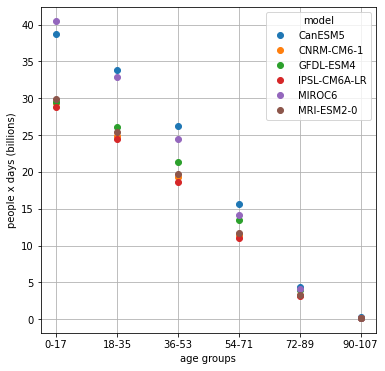

In [215]:
fig, ax = plt.subplots(figsize=(6,6))
df_plot = df_18y_pd / 1e9
df_plot.plot(marker='o',linestyle='None', ax=ax)
plt.ylabel('people x days (billions)')
plt.xlabel('age groups')
plt.xticks(df_plot.index);
plt.grid()
ax.set_xticks(ticks=ax.get_xticks(), labels=[f'{x}-{x+17}' for x in df_plot.index], rotation='horizontal');

#plt.savefig(os.path.join(figdir,'people_days_18y_TX99.png'), dpi=300, transparent=False)


In [217]:
df_18y_pd.mean(axis=1) / 1e9

age_ranges
0     32.768737
18    27.934788
36    21.632482
54    12.883903
72     3.699597
90     0.202631
dtype: float64

In [218]:
df_18y_pd.median(axis=1) / 1e9

age_ranges
0     29.689597
18    25.757319
36    20.589447
54    12.583032
72     3.660470
90     0.201714
dtype: float64

### other globally aggregated results: child v. adults 

#### some more fxns: to move

In [ ]:
def calc_summary_child_v_adults():
    
    pass
    

In [293]:
def calc_weighted_average(df_values, df_weights, start, stop):
    
    ''' stop is excluded'''
    print(f'note: loc {stop} is excluded')
    
    weighted_avg = df_values.iloc[start:stop].multiply(df_weights[start:stop], axis = 0).sum(axis=0).divide(df_weights[start:stop].sum(), axis=0)
    
    return weighted_avg
    
    

In [ ]:
def format_large_numbers(x):
    try:
        x = float(x)
        if abs(x) >= 1e9:
            return f'{x/1e9:.1f}B'
        if abs(x) >= 1e6:
            return f'{x/1e6:.1f}M'
        if abs(x) >= 1e3:
            return f'{x/1e3:.1f}K'
        if abs(x) <= 1e2:
            return f'{x:.1f}'
        return str(x)
    except ValueError:
        return x


In [226]:
da_n_people_TX99_1y.features

<xarray.DataArray 'features' (features: 6)>
array(['n_atleast_1', 'n_atleast_5', 'n_atleast_10', 'n_atleast_20',
       'n_atleast_50', 'n_whrincr'], dtype=object)
Coordinates:
  * features  (features) object 'n_atleast_1' 'n_atleast_5' ... 'n_whrincr'

In [227]:
 da_prop_people_TX99_1y.features

<xarray.DataArray 'features' (features: 7)>
array(['prop_atleast_1', 'prop_atleast_5', 'prop_atleast_10',
       'prop_atleast_20', 'prop_atleast_50', 'prop_whrincr', 'n_people'],
      dtype=object)
Coordinates:
  * features  (features) object 'prop_atleast_1' 'prop_atleast_5' ... 'n_people'

In [239]:
# people x days 

da_nAHD_TX99_percapita_peopledays_1y.features

<xarray.DataArray 'features' (features: 3)>
array(['per_capita_days', 'people_days', 'n_people'], dtype=object)
Coordinates:
  * features  (features) object 'per_capita_days' 'people_days' 'n_people'

In [328]:
# number of children versus number of adults living in places where increase 
ch_end = 18
ad_end = 58 

df = da_n_people_TX99_1y.sel(features='n_whrincr').to_pandas().T

children_whr_increase = df.iloc[0:ch_end].sum(axis=0)
adults_whr_increase = df.iloc[40:ad_end].sum(axis=0)

In [329]:
df = da_nAHD_TX99_percapita_peopledays_1y.sel(features='people_days').to_pandas().T

children_peopledays = df.iloc[0:ch_end].sum(axis=0) 
adults_peopledays = df.iloc[40:ad_end].sum(axis=0)

In [330]:
df_values = da_nAHD_TX99_percapita_peopledays_1y.sel(features='per_capita_days').to_pandas().T
df_npeople = da_nAHD_TX99_percapita_peopledays_1y.sel(features='n_people').to_pandas().T

children_percapita =  calc_weighted_average(df_values, df_npeople, 0, ch_end)
adults_percapita = calc_weighted_average(df_values, df_npeople, 0, ad_end)

note: loc 18 is excluded
note: loc 58 is excluded


In [331]:
df_summary = pd.concat([children_whr_increase,
           adults_whr_increase,
          children_peopledays,
          adults_peopledays,
          children_percapita,
          adults_percapita], axis=1,
         keys= ['children_whr_increase',
           'adults_whr_increase',
          'children_peopledays',
          'adults_peopledays',
          'children_percapita',
          'adults_percapita'])

In [332]:

df_summary.applymap(format_large_numbers)

# this gives the same as above, but different to my old function - check why !! 
# if you do 0-18 included and 40-58 included number of people is the same but people x days and per capita days are different
# see attr-hw-isimip3b-TX99-exposure-dev0 & understand why 

,children_whr_increase,adults_whr_increase,children_peopledays,adults_peopledays,children_percapita,adults_percapita
model,,,,,,
CanESM5,2.1B,1.5B,38.7B,24.1B,18.4,17.4
CNRM-CM6-1,2.1B,1.5B,29.4B,17.6B,14.0,13.0
GFDL-ESM4,2.0B,1.5B,29.5B,19.9B,14.6,14.0
IPSL-CM6A-LR,2.2B,1.6B,28.8B,17.0B,13.4,12.3
MIROC6,1.9B,1.4B,40.4B,22.2B,21.2,18.8
MRI-ESM2-0,2.0B,1.4B,29.9B,18.1B,14.9,13.9


In [333]:
pd.DataFrame(df_summary.median(axis=0), columns=['median']).applymap(format_large_numbers)

,median
children_whr_increase,2.1B
adults_whr_increase,1.5B
children_peopledays,29.7B
adults_peopledays,19.0B
children_percapita,14.7
adults_percapita,13.9


## Multi model plots: delta-I

In [395]:
def calc_averagedeltaI_peragegroup(gs_population, 
                                   GCMs, 
                                   da_deltaI_all, 
                                   ages_values=range(0,100),
                                   grouped = True,
                                   size_win = 10
                                   ):
    # initiate empty dataarray 
    da_master = None

    for GCM in GCMs:

        da_deltaI = da_deltaI_all.sel(model=GCM)

        # initiate empty data array
        df_out = pd.DataFrame(index=ages_values)
        df_out['avg_deltaI'] = np.nan
        df_out['n_people'] = np.nan

        for i in range(len(df_out)):

            # population weighted average of deltaI, by cohort weight
            pop_weighted_avg = (da_deltaI * gs_population.isel(ages=i) ).sum(
                dim=('lat','lon')) / gs_population.isel(ages=i).sum(dim=('lat','lon'))

            df_out.loc[i,f'avg_deltaI'] = pop_weighted_avg

            # total people of each age 
            n_people = gs_population_global.isel(ages=i).sum().values
            df_out.loc[i,f'n_people'] = n_people

            # convert to dataarray
            if grouped == False:
                da = xr.DataArray(df_out, dims = ('age_ranges', 'features')).assign_coords(model=GCM)

        if grouped == True:
            # group by doing a weighted sum - maybe there's too much pre-aggregation and I should do this at gridscale not in this fxn on dataframe... 
            age_ranges = [i * size_win for i in range(df_out.index[-1] // size_win + 1)]
            df_out_weighted = df_out['avg_deltaI'].multiply(df_out['n_people'], axis = 0) # weighted average: per capita x number of people of each age group
            sum_percapita_times_people = df_out_weighted.groupby(by= ((df_out_weighted.index // size_win) + 1)).sum()
            sum_people_bracket = df_out['n_people'].groupby(by= ((df_out.index // size_win) + 1)).sum() # could add this as a column !!!
            data_grouped = sum_percapita_times_people.divide(sum_people_bracket, axis = 0).rename('avg_deltaI')
            df_out_grouped = pd.concat([data_grouped, sum_people_bracket], axis=1 ) #.reindex(age_ranges)
            df_out_grouped.index = age_ranges
            
            # convert to dataarray
            da = xr.DataArray(df_out_grouped, dims = ('age_ranges', 'features')).assign_coords(model=GCM)


            # concat for all GCMs
            if da_master is None:
                da_master = da.copy()
            else:
                da_master = xr.concat([da_master, da], dim='model')

    return da_master

            

In [423]:
da_avgdeltaI_TX99_10y = calc_averagedeltaI_peragegroup(gs_population_global, 
                               GCMs, 
                               da_deltaI_TX99, 
                               ages_values=range(0,100),
                               grouped = True,
                               size_win = 10
                               )


In [424]:
da_avgdeltaI_TX99_18y = calc_averagedeltaI_peragegroup(gs_population_global, 
                               GCMs, 
                               da_deltaI_TX99, 
                               ages_values=range(0,100),
                               grouped = True,
                               size_win = 18
                               )

In [399]:
da_avgdeltaI_TX99_10y.isel(model=0).to_pandas()

features,avg_deltaI,n_people
age_ranges,,
0,1.681682,1.209654e+09
10,1.689111,1.168053e+09
20,1.696614,1.090061e+09
30,1.658146,1.074564e+09
40,1.652492,9.114861e+08
50,1.600878,7.894684e+08
60,1.604999,5.710533e+08
70,1.597710,3.161174e+08
80,1.625094,1.206272e+08


In [426]:
#da_avgdeltaI_TX99_18y

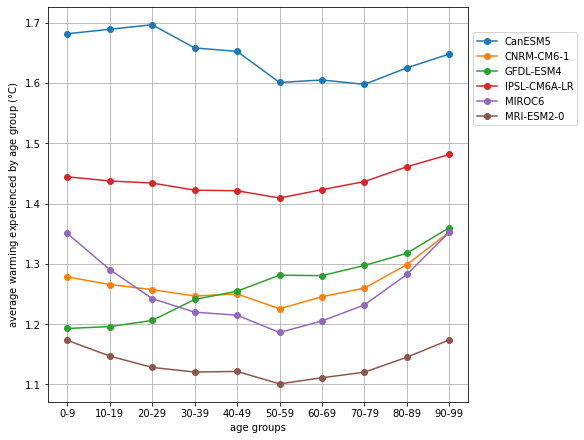

In [456]:
fig, ax = plt.subplots(figsize=(8,6), layout='constrained')

data_plot = da_avgdeltaI_TX99_10y.sel(features='avg_deltaI').to_pandas().T
data_plot.plot(ax=ax, marker='o')

plt.ylabel('average warming experienced by age group ($\degree$C)')
plt.xlabel('age groups')
plt.xticks(data_plot.index);
plt.grid()
ax.set_xticks(ticks=ax.get_xticks(), labels=[f'{x}-{x+9}' for x in data_plot.index], rotation='horizontal');
plt.legend(loc=(1.01,.7))


#plt.savefig(os.path.join(figdir,'avgdeltaI_10y_TX99.png'), dpi=300, transparent=False)

In [452]:
data_plot.round(2)

model,CanESM5,CNRM-CM6-1,GFDL-ESM4,IPSL-CM6A-LR,MIROC6,MRI-ESM2-0
age_ranges,,,,,,
0,1.68,1.28,1.19,1.44,1.35,1.17
10,1.69,1.27,1.20,1.44,1.29,1.15
20,1.70,1.26,1.21,1.43,1.24,1.13
30,1.66,1.25,1.24,1.42,1.22,1.12
40,1.65,1.25,1.25,1.42,1.21,1.12
50,1.60,1.23,1.28,1.41,1.19,1.10
60,1.60,1.25,1.28,1.42,1.21,1.11
70,1.60,1.26,1.30,1.44,1.23,1.12
80,1.63,1.30,1.32,1.46,1.28,1.15


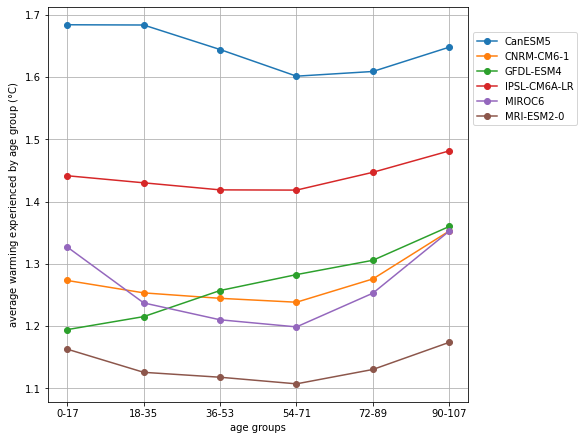

In [454]:
fig, ax = plt.subplots(figsize=(8,6), layout='constrained')

data_plot = da_avgdeltaI_TX99_18y.sel(features='avg_deltaI').to_pandas().T
data_plot.plot(marker='o', ax=ax)

plt.ylabel('average warming experienced by age group ($\degree$C)')
plt.xlabel('age groups')
plt.xticks(data_plot.index);
plt.grid()
ax.set_xticks(ticks=ax.get_xticks(), labels=[f'{x}-{x+17}' for x in data_plot.index], rotation='horizontal');
plt.legend(loc=(1.01,.7))

#plt.savefig(os.path.join(figdir,'avgdeltaI_18y_TX99.png'), dpi=300, transparent=False)